# Libraries

In [5]:
!pip install lime

In [6]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,learning_curve
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import lime
import lime.lime_tabular
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance

# Load & Split Datatset

In [7]:
df = pd.read_csv("/content/df_cleaned.csv")
df

,last_pymnt_d,total_rec_prncp,last_pymnt_amnt,out_prncp,total_rec_late_fee,last_fico_range_high,installment,loan_amnt,total_rec_int,out_prncp_inv,total_pymnt,funded_amnt_inv,recoveries,debt_settlement_flag,hardship_flag,mo_sin_old_rev_tl_op,revol_util,dti,all_util,annual_inc,loan_status
0,17,-0.332581,-0.372797,0.420080,-0.261895,0.281611,-0.473027,-0.461473,0.413942,0.420298,-0.222676,-0.461004,-0.445598,0,0,-0.307356,0.608376,0.558953,0.915820,-1.203816,0
1,31,-0.840560,-0.473603,-0.629220,-0.261895,1.244049,-1.608631,-1.601510,-1.081823,-0.629167,-1.102958,-1.601271,-0.445598,0,0,-0.187187,-1.880835,-1.233491,-0.049124,0.274631,1
2,27,-0.250720,-0.222228,2.263937,-0.261895,0.883135,1.252073,1.058575,-0.380182,2.264445,-0.393139,1.059353,-0.445598,0,0,-0.980297,0.431193,-0.223328,0.379740,2.227297,1
3,39,-0.458023,0.161605,-0.629220,-0.261895,0.161306,-1.364264,-1.373503,-0.909433,-0.629167,-0.727889,-1.373218,-0.445598,0,0,-1.472987,0.314511,-0.337836,0.433348,-1.231711,1
4,5,-0.415519,0.220569,-0.629220,-0.261895,0.221459,-1.317547,-1.348168,-0.834440,-0.629167,-0.669368,-1.347878,-0.445598,0,0,0.738107,1.273894,0.117928,1.559116,-0.841178,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119281,36,1.072123,0.066746,-0.629220,-0.261895,0.822982,-0.473196,-0.461473,-0.593052,-0.629167,0.659788,-0.461004,-0.445598,0,0,0.353569,0.720736,-0.931916,0.111700,4.179963,1
119282,26,0.475587,-0.417190,-0.629220,-0.261895,-1.462808,1.079697,0.555059,1.491599,-0.629167,0.784970,0.555735,-0.445598,0,0,-0.727944,0.405263,-0.997673,2.309628,1.390440,0
119283,27,-0.983894,-0.414521,0.132695,-0.261895,1.003439,-0.951061,-1.078993,-0.949884,0.132868,-1.184196,-1.078649,-0.445598,0,0,2.336344,-0.109001,0.109992,-0.746028,-1.426978,1
119284,13,0.639197,-0.321768,-0.629220,3.433568,-0.981589,0.636417,1.311917,2.824325,-0.629167,1.330306,1.312745,-0.445598,1,0,-0.259288,-0.484975,-0.158705,-0.049124,0.001258,0


In [8]:
# separate features and target
X = df.drop(columns=['loan_status'])
y = df['loan_status']

In [9]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression Model

In [10]:
def train_logistic_regression_model(
    features,
    labels,
    test_data_ratio=0.2,
    seed=42,
    max_iterations=1000,
    random_state=42,
    **kwargs
):
    """
    Train a logistic regression model with custom settings and evaluate accuracy, confusion matrix, classification report, and ROC curve.

    Parameters:
        features (array-like): Input features (X).
        labels (array-like): Target values (y).
        test_data_ratio (float): Fraction of data for testing (default 0.2).
        seed (int): Random seed for reproducibility (default 42).
        max_iterations (int): Max number of iterations for training (default 1000).
        random_state (int): Random state for train-test split and model initialization.
        **kwargs: Additional hyperparameters for LogisticRegression.

    Returns:
        model: Trained LogisticRegression model.
        accuracy: Accuracy on the test set.
        y_pred: Predicted values on the test set.
    """
    # Split dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, test_size=test_data_ratio, random_state=random_state
    )

    # Initialize and train the logistic regression model
    model = LogisticRegression(max_iter=max_iterations, random_state=random_state, **kwargs)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate model performance (accuracy)
    accuracy = accuracy_score(y_test, y_pred)

    # Print Accuracy
    print("Accuracy:", accuracy)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Classification Report
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # ROC Curve
    probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    roc_auc = roc_auc_score(y_test, probs)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    return model, accuracy, y_pred

Accuracy: 0.9649481295190192


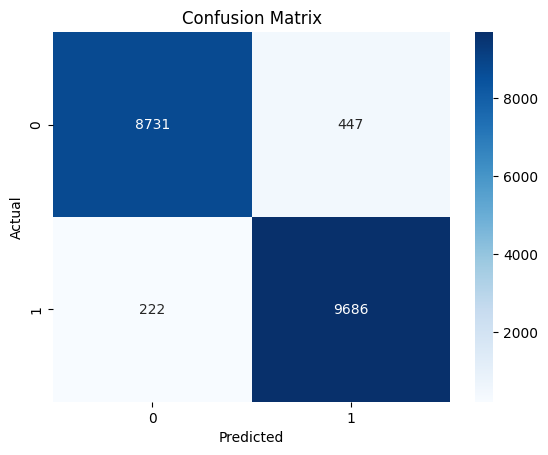

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.96      9178
           1       0.96      0.98      0.97      9908

    accuracy                           0.96     19086
   macro avg       0.97      0.96      0.96     19086
weighted avg       0.97      0.96      0.96     19086



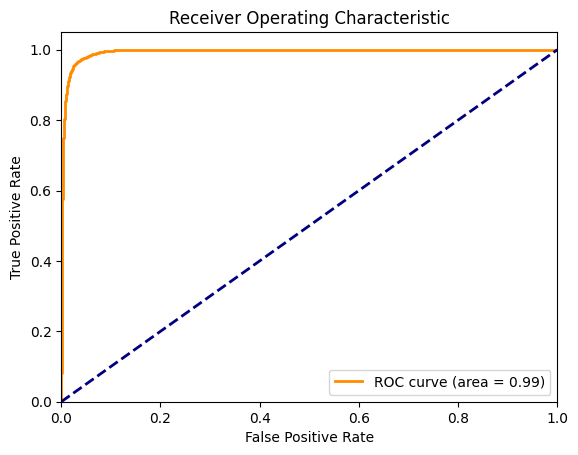

In [11]:
model, accuracy, predictions = train_logistic_regression_model(
    X_train,
    y_train,
    max_iterations=1000,
    random_state=42
)

# performance visualization

## Learning Curve

In [12]:
def plot_learning_curve(estimator, X, y, title='Learning Curve'):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, scoring='accuracy',
        train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', label='Cross-validation score')
    plt.title(title)
    plt.xlabel('Training examples')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

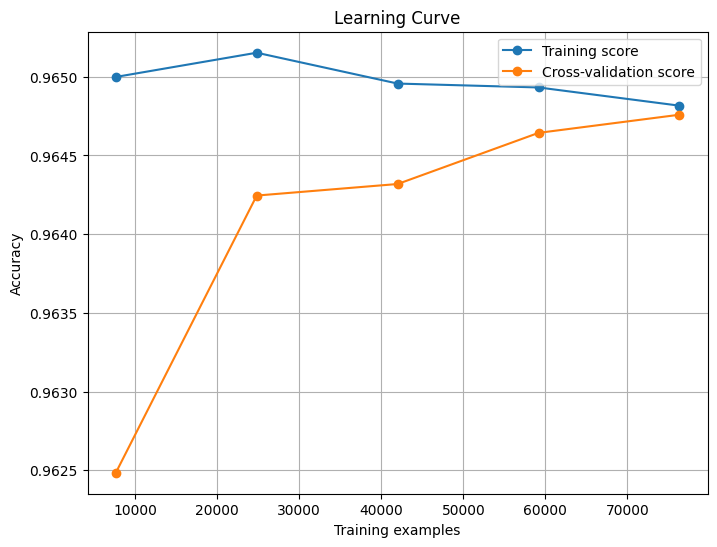

In [13]:
plot_learning_curve(LogisticRegression(max_iter=1000),  X_train, y_train)

* Good fit

# Interpretability

In [14]:
def interpret_coefficients(model, feature_names):
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': model.coef_[0],
        'Odds Ratio': np.exp(model.coef_[0])
    }).sort_values(by='Odds Ratio', ascending=False)

    # print(coef_df)
    return coef_df

interpret_coefficients(model, X_train.columns)

,Feature,Coefficient,Odds Ratio
1,total_rec_prncp,7.256477,1417.254587
9,out_prncp_inv,7.191309,1327.840666
3,out_prncp,7.190743,1327.089310
10,total_pymnt,5.071220,159.368636
5,last_fico_range_high,2.710886,15.042603
2,last_pymnt_amnt,2.564851,12.998724
16,revol_util,0.293061,1.340525
0,last_pymnt_d,0.152412,1.164640
19,annual_inc,0.086907,1.090795
18,all_util,0.025208,1.025529


* coefficients:
  * Large coefficients (positive or negative) = high influence.
  * Small coefficients ≈ 0 = low influence.
* Odds Ratio:
  * Odds Ratio >> 1: Feature strongly increases the chance of positive outcome.
  * Odds Ratio << 1: Feature strongly decreases the chance (increases risk).
  * Odds Ratio ≈ 1: Not much impact.

# Interpretability Techniques

## Local

### SHAP

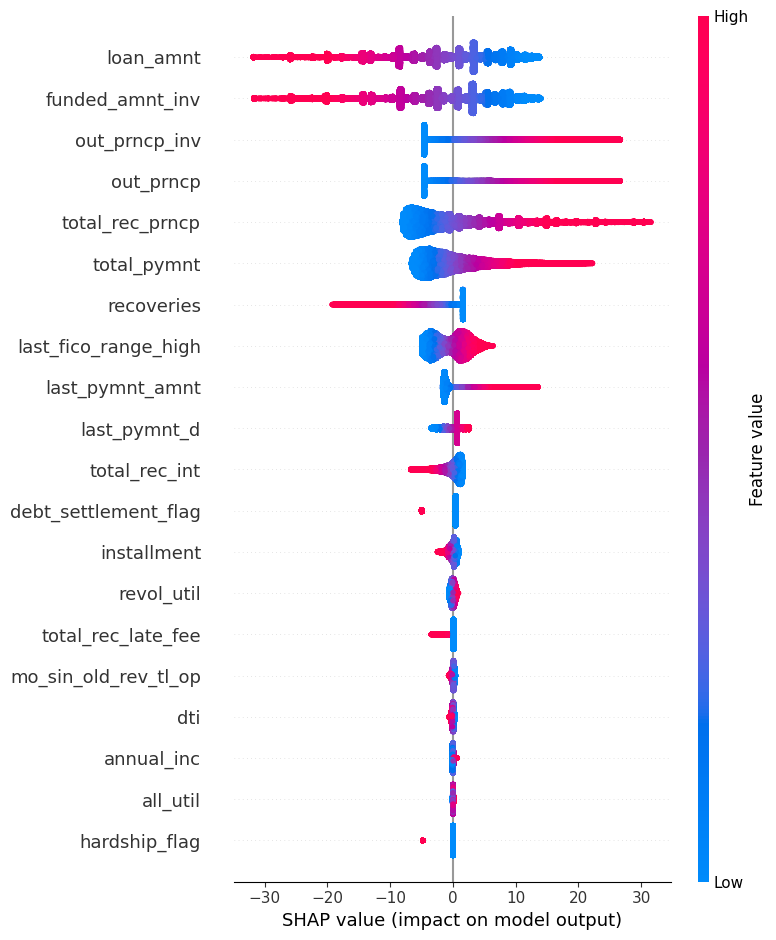

In [15]:
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

shap.summary_plot(shap_values, X)

* Loan amount and funded amount have a strong influence on the model, as indicated by their wider spread of SHAP values and their positioning towards the higher end of the x-axis. When these features are high, their impact on the prediction is significant.

* Features like total payment has noticeable effects on the model.

* Features such as hardship_flag and annual income seem to have less impact, indicated by the narrower spread of SHAP values around zero.

### LIME

In [16]:
# Initialize the explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X.columns,
    class_names=['Class 0', 'Class 1'],
    mode='classification'
)

# Explain a single prediction
i = 0  # Index of the instance to explain
exp = lime_explainer.explain_instance(X_test.iloc[i], model.predict_proba, num_features=10)

# Display explanation
exp.show_in_notebook(show_table=True)

/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

Visual shows
*  the model predicted Class 1 with full confidence (probability = 1.00)
* funded_amnt_inv <= -1.35 and loan_amnt <= -0.71 had the strongest positive influence toward predicting Class 1

table shows the actual values of the features for this individual prediction
* funded_amnt_inv = -1.35, loan_amnt = -1.35, and hardship_flag = 0.00.

**LIME indicates this prediction is strongly influenced by low funding, low loan amounts, low principal outstanding, and no hardship flag — pushing the model to confidently predict Class 1**

## Global

###  PDP

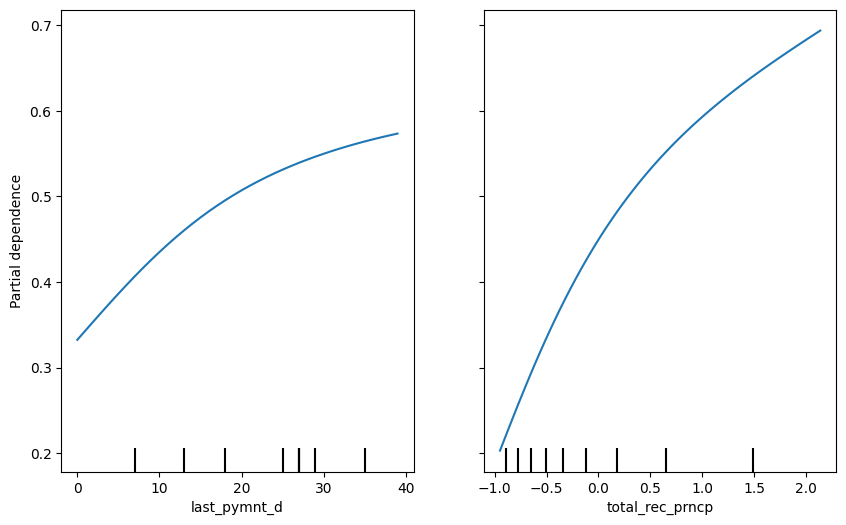

In [18]:
features_to_plot = [X.columns[0], X.columns[1]]

fig, ax = plt.subplots(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(model, X_train, features_to_plot, ax=ax)
plt.show()

Found 20 numeric features: ['last_pymnt_d', 'total_rec_prncp', 'last_pymnt_amnt', 'out_prncp', 'total_rec_late_fee', 'last_fico_range_high', 'installment', 'loan_amnt', 'total_rec_int', 'out_prncp_inv', 'total_pymnt', 'funded_amnt_inv', 'recoveries', 'debt_settlement_flag', 'hardship_flag', 'mo_sin_old_rev_tl_op', 'revol_util', 'dti', 'all_util', 'annual_inc']
Skipping feature 'debt_settlement_flag' due to error: cannot reshape array of size 1 into shape (2)
Skipping feature 'hardship_flag' due to error: cannot reshape array of size 1 into shape (2)


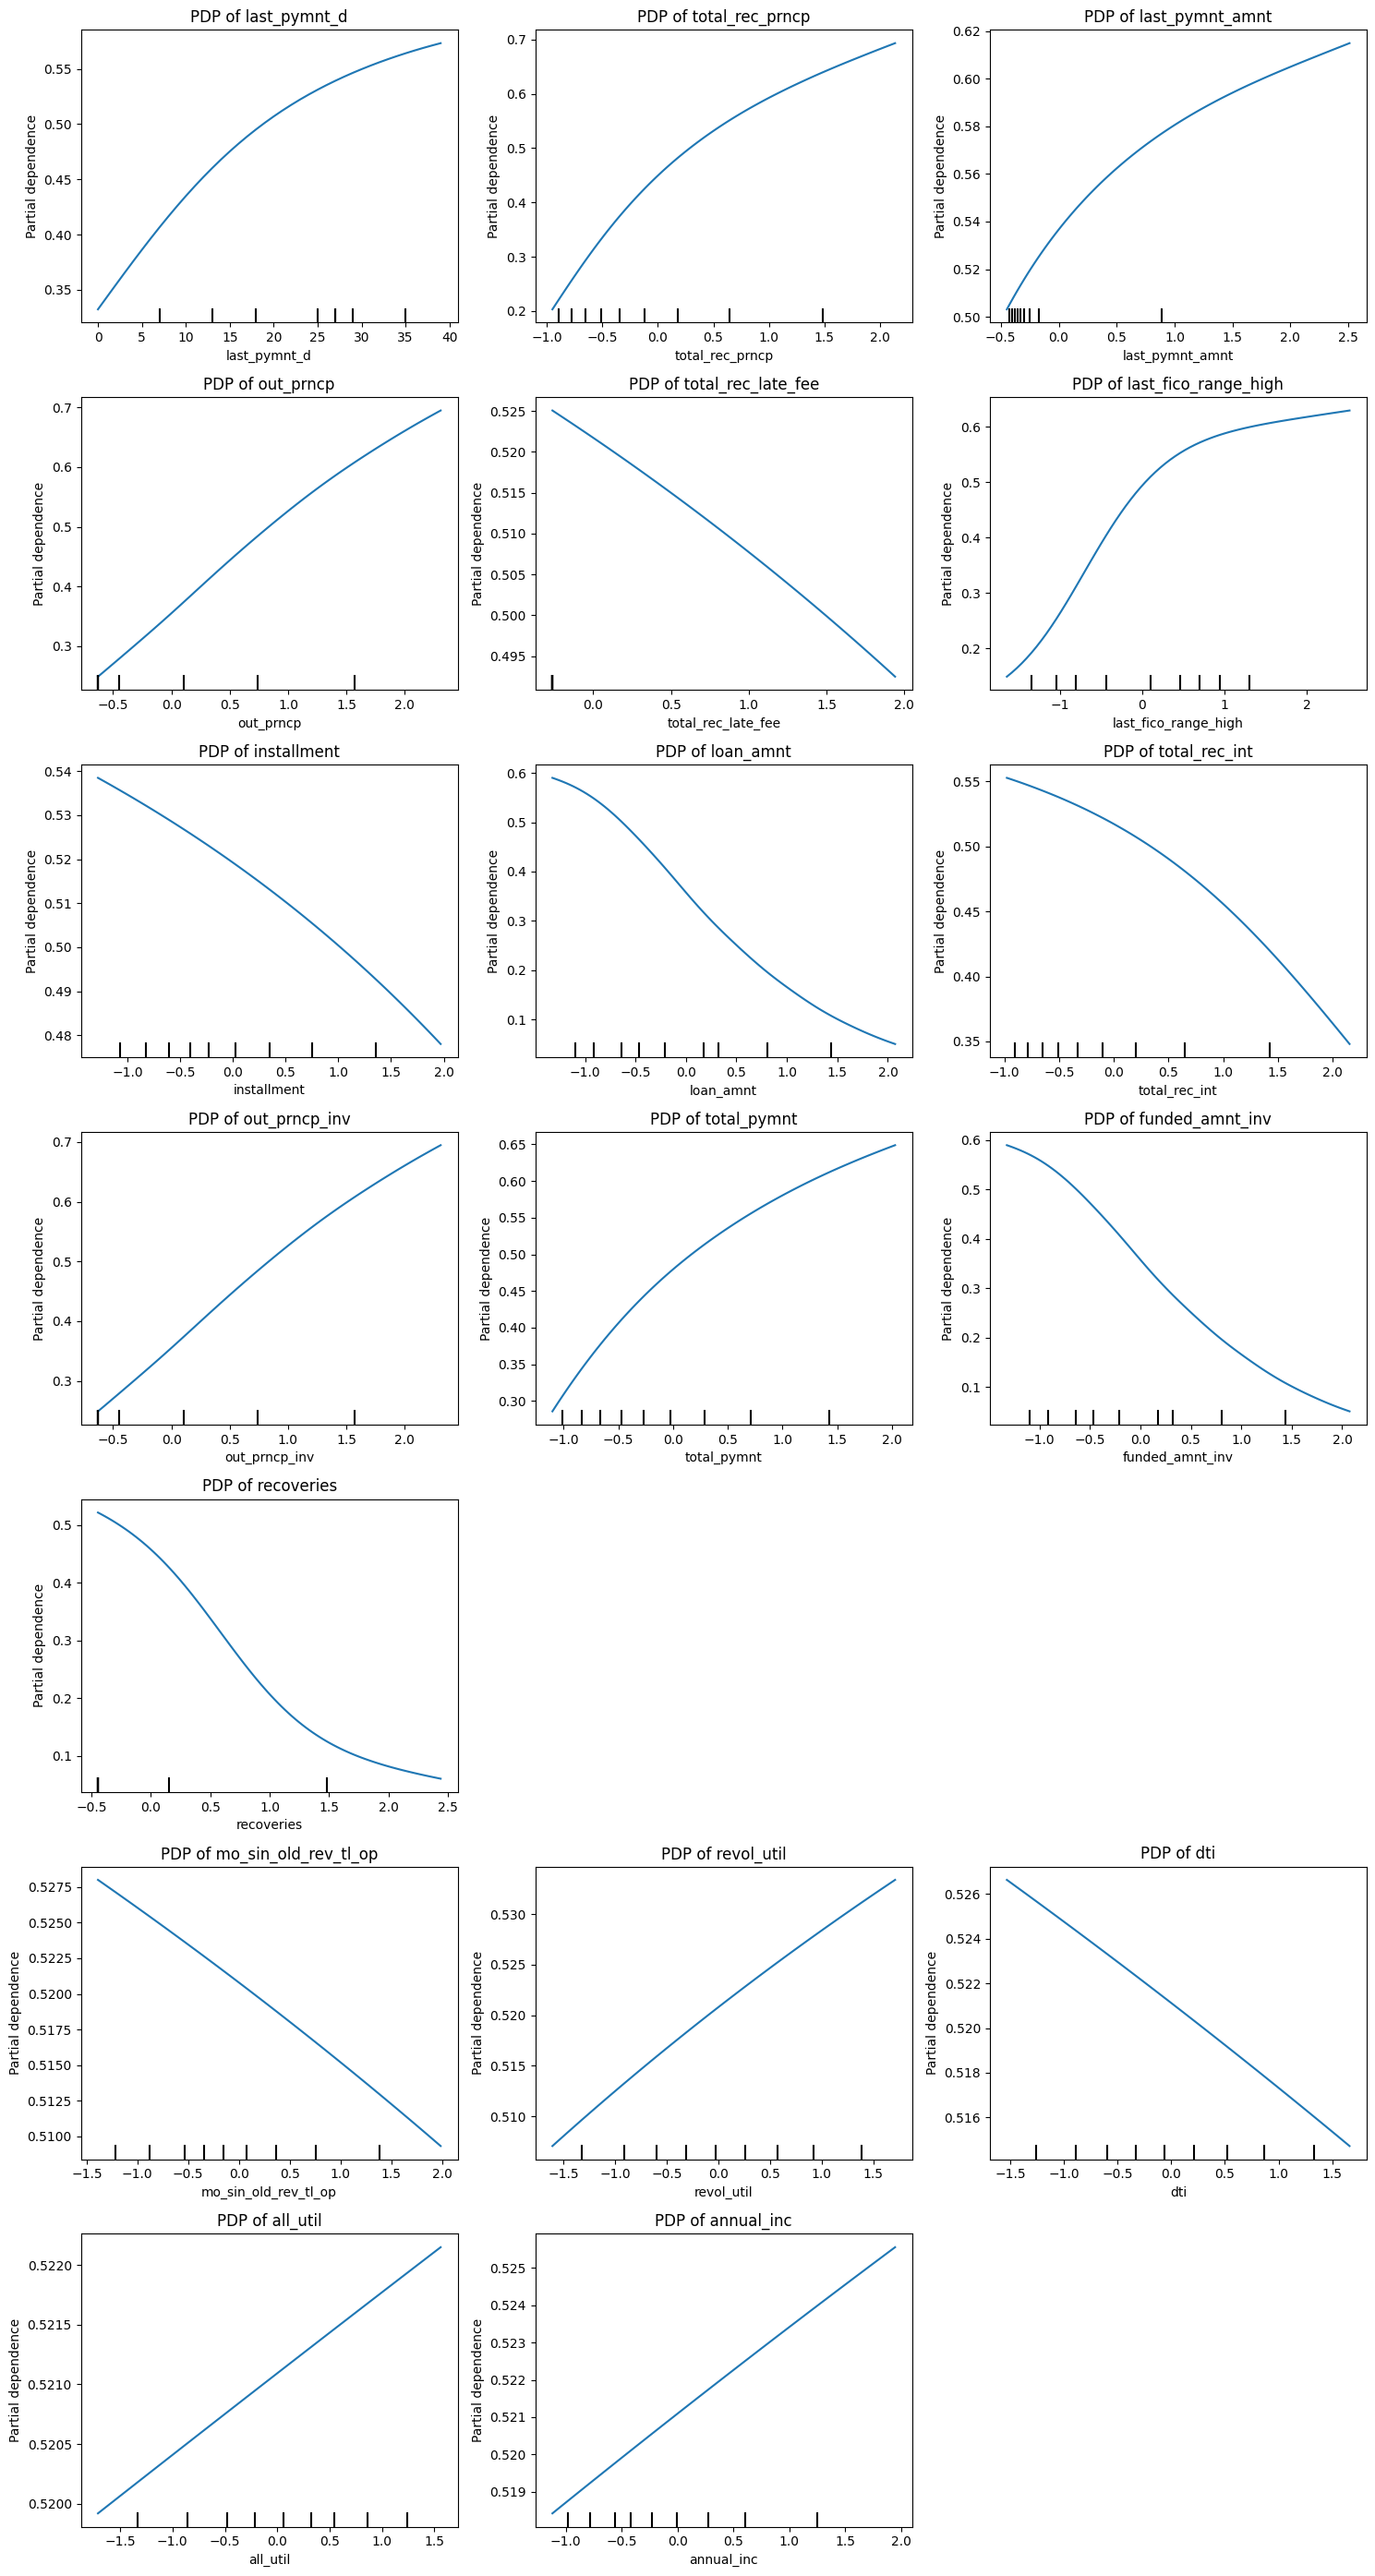

In [23]:

# Get all feature names
all_features = X.columns.tolist()

# Filter numeric features only
numeric_features = [col for col in all_features if pd.api.types.is_numeric_dtype(X_train[col])]

print(f"Found {len(numeric_features)} numeric features: {numeric_features}")

# Set up subplots: calculate rows needed (3 plots per row)
n_cols = 3
n_rows = (len(numeric_features) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))

# Flatten axes
axes = axes.flatten()

# Plot PDP for each numeric feature
for i, feature in enumerate(numeric_features):
    try:
        PartialDependenceDisplay.from_estimator(
            model,
            X_train,
            [feature],
            ax=axes[i],
        )
        axes[i].set_title(f"PDP of {feature}")
    except Exception as e:
        print(f"Skipping feature '{feature}' due to error: {e}")
        fig.delaxes(axes[i])  # Remove the failed plot slot if it errors

# Hide any empty subplots (in case of skipped plots)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


* Upward slope ->	Higher values of the feature increase the prediction.
* Downward slope ->	Higher values of the feature decrease the prediction.
* Flat line ->	Feature has little or no impact on the prediction.
* Nonlinear shapes ->	Show interactions or thresholds in how the feature affects outcome.

###  PFI

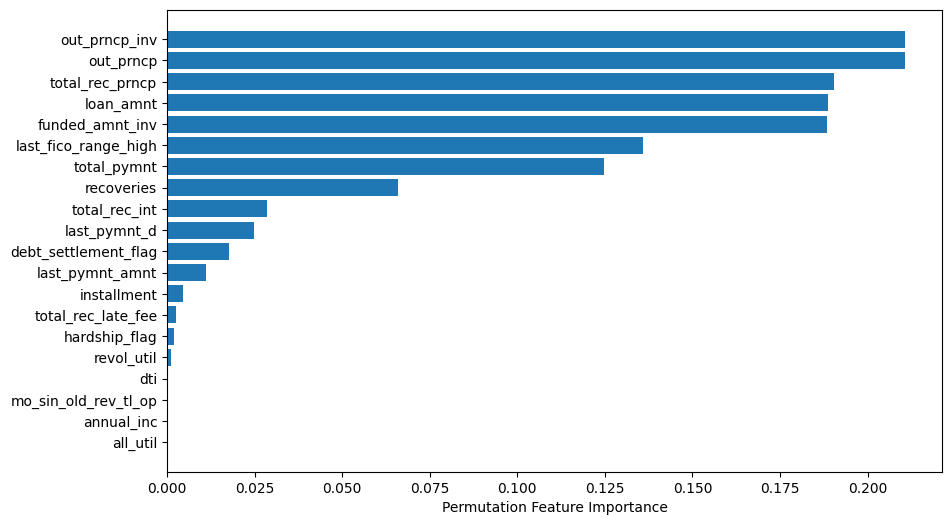

In [19]:
pfi_results = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=42)

sorted_idx = pfi_results.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.barh(X.columns[sorted_idx], pfi_results.importances_mean[sorted_idx])
plt.xlabel("Permutation Feature Importance")
plt.show()

Top Features:
* out_prncp_inv, out_prncp, total_rec_prncp – These are the most important features, suggesting that principal amounts (either outstanding or received) heavily influence the model's predictions.

* loan_amnt and funded_amnt_inv – The original loan amount and amount actually funded are also highly influential.

* last_fico_range_high – Indicates that the FICO score range is a strong predictor, likely related to creditworthiness.

* total_pymnt and recoveries – These reflect historical repayment behavior and recoveries from default, which are understandably important.

Less Important Features:
* annual_inc, all_util, mo_sin_old_rev_tl_op – These are among the least important in this context, meaning the model's accuracy doesn't change much when these are shuffled.

* Flags such as hardship_flag, debt_settlement_flag, and last_pymnt_amnt show moderate to low importance.